# Noised trajectories

In [215]:
import numpy as np
import numpy.random as alea
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [217]:
import pickle
import pandas as pd
record = pd.read_pickle('../2017_OptimalPrecision/DataRecording/dt_0.001/'+'HW_tau=0.013_dt=0.001_tT=0.05_tR=0.05_k=0.0001_niter=5000_xT=10_v=5.0.pkl')

In [218]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [229]:
tau = 0.013
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.000005

In [230]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

In [221]:
t_T = .05# saccade duration
t_R = .05 # pursuit duration
T = int(np.round(t_T/dt))
R = int(np.round(t_R/dt))
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 10
x0[0] = 0
#v = 10*np.cos(20*np.pi*time) # velocity of the target (deg/s)

In [222]:
def xT_f(t):
    return np.array([xT[0], 0])

In [223]:
xx = np.zeros(T+R+1)
vv = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    xx[i] = xT[0]
    vv[i] = 0

In [224]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [225]:
def state_vector(u, t):
    if t == 0:
        return x0
    else:
        w = np.zeros(len(u))
        for i in np.arange(t):
            w[i] = alea.normal(0,k*(u[i])**2)
        return (ci[:,0:t]*np.flipud(u[0:t]+w[0:t])).sum(axis = 1)

In [226]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return (ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [227]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

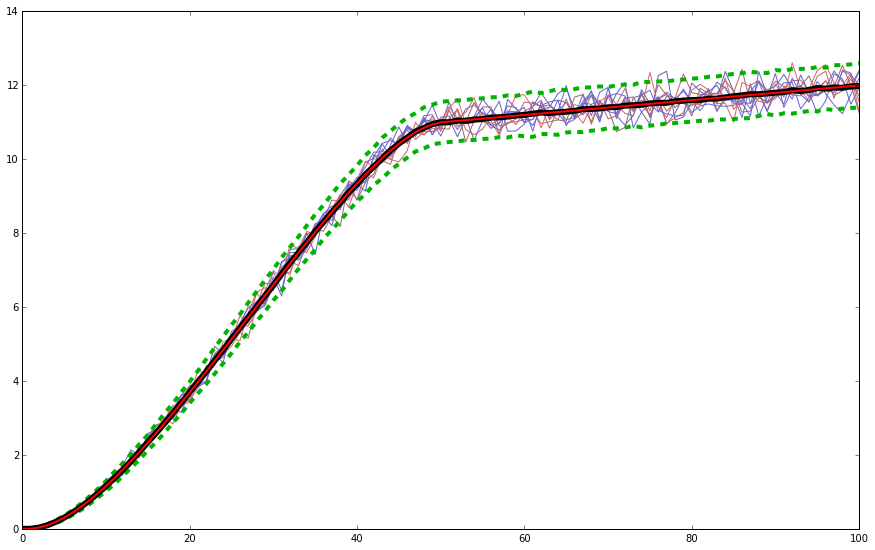

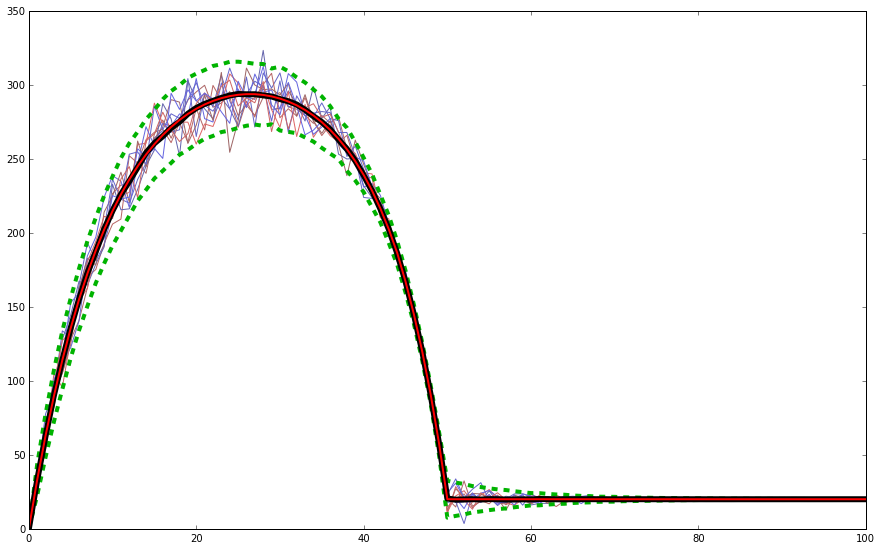

In [245]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ntest = 500
poss = np.zeros((ntest,T+R+1))
vels = np.zeros((ntest,T+R+1))

nshow = 10

col = np.zeros((nshow,3))
for i in np.arange(nshow):
    if i%2  == 0:
        col[i] = 1-alea.rand()/2, .4, .4
    else:
        col[i] = .4, .4, 1-alea.rand()/2

for j in np.arange(ntest):
    pos1 = np.zeros(T+R+1)
    pos2 = np.zeros(T+R+1)
    vel1 = np.zeros(T+R+1)
    vel2 = np.zeros(T+R+1)
    for i in np.arange(T+R+1):
        state_v = state_vector(record.signal[1200000], i)
        pos1[i] = record.position[1200000][i]
        pos2[i] = state_v[0]
        vel1[i] = record.velocity[1200000][i]
        vel2[i] = state_v[1]
    poss[j, :] = pos2
    vels[j, :] = vel2
pos_mean = np.mean(poss, axis = 0)
vel_mean = np.mean(vels, axis = 0)
for j in np.arange(nshow):
    plt.figure(1)
    plt.plot(poss[j*ntest//nshow], color = col[j])

ecart_pos = np.zeros(T+R+1)
ecart_vel = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ecart_pos[i] = np.sqrt(np.var(poss[:,i]))
for i in np.arange(T+R+1):
    ecart_vel[i] = np.sqrt(np.var(vels[:,i]))
Iplus_pos = np.zeros(T+R+1)
Imoins_pos = np.zeros(T+R+1)
Iplus_vel = np.zeros(T+R+1)
Imoins_vel = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    Iplus_pos[i] = record.position[1200000][i]+2*ecart_pos[i]
    Imoins_pos[i] = record.position[1200000][i]-2*ecart_pos[i]
    Iplus_vel[i] = record.velocity[1200000][i]+2*ecart_vel[i]
    Imoins_vel[i] = record.velocity[1200000][i]-2*ecart_vel[i]
plt.plot(Iplus_pos, lw = 4, ls = '--', color =(0,0.7,0))
plt.plot(Imoins_pos, lw = 4, ls = '--', color =(0,0.7,0))
plt.plot(pos_mean, lw = 6, color ='black')
plt.plot(pos1, lw = 2, color ='red')


fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

for j in np.arange(nshow):
    plt.figure(2)
    plt.plot(vels[j*ntest//nshow], color = col[j])

plt.plot(Iplus_vel, lw = 4, ls = '--', color =(0,0.7,0))
plt.plot(Imoins_vel, lw = 4, ls = '--', color =(0,0.7,0))
plt.plot(vel_mean, lw = 6, color = 'black')
plt.plot(vel1, lw = 2, color = 'red')

In [231]:
pos1

array([  0.        ,   0.        ,   0.03322766,   0.09633163,
         0.18629248,   0.30038919,   0.43616886,   0.59141952,
         0.76414548,   0.95254516,   1.15499109,   1.37001179,
         1.59627541,   1.83257489,   2.07781454,   2.33099785,
         2.59121633,   2.85763941,   3.12950509,   3.40611148,
         3.68680883,   3.97099221,   4.25809466,   4.54758068,
         4.83894007,   5.13168199,   5.42532912,   5.71941194,
         6.013463  ,   6.30701105,   6.59957495,   6.89065736,
         7.17973791,   7.46626586,   7.74965202,   8.02925983,
         8.30439525,   8.57429534,   8.83811515,   9.09491267,
         9.34363117,   9.58307877,   9.8119043 ,  10.02856895,
        10.23131275,  10.41811502,  10.58546266,  10.73068602,
        10.8506725 ,  10.94179261,  10.99981663,  11.01982366,
        11.03982442,  11.05982516,  11.07982589,  11.09982659,
        11.11982729,  11.13982796,  11.15982862,  11.17982927,
        11.19982989,  11.2198305 ,  11.2398311 ,  11.25

In [232]:
u = np.zeros(T+R)

for i in np.arange(T+R):
    u[i] = (vel1[i+1]-(1-dt*beta)*vel1[i])/dt

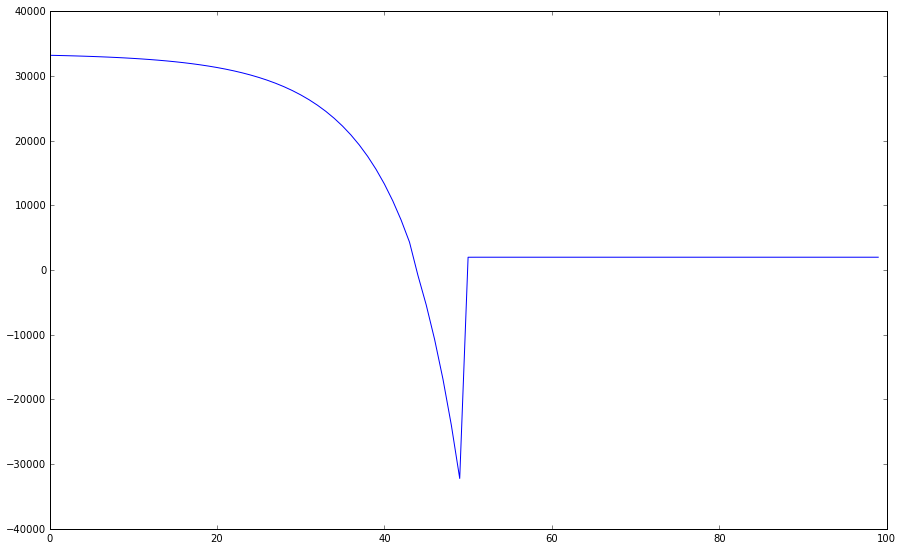

In [233]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(u)